# <font color= #13c113  >Word Embeddings</font> with Keras

![Deep Learning with Python](https://images-na.ssl-images-amazon.com/images/I/41DWjHboiyL._SX258_BO1,204,203,200_.jpg)


## Adapted from:

### [Section 6.1-using-word-embeddings](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-using-word-embeddings.ipynb)

## By François Chollet


---

<font size=4 >Summer Seminar:</font> <font size=4 color= orange>Practical Introduction to Deep Learning & Keras</font>

 <img src="https://pbs.twimg.com/profile_images/969243109208018946/w2GzDfiC_400x400.jpg" alt="IPTC" height="50" width="50"> 
 ## * [IPTC](https://iptc.upm.es/) and [MSTC](http://mstc.ssr.upm.es/big-data-track)
 
---
---




---

## A popular and powerful way to associate a vector with a word is the use of dense "word vectors", also called "word embeddings".

![Word embeddings](https://s3.amazonaws.com/book.keras.io/img/ch6/word_embeddings.png)

from François Chollet book.keras.io

- #### One-hot encoding are binary, sparse (mostly made of zeros) and very high-dimensional (same dimensionality as the number of words in the vocabulary), "word embeddings" are low-dimensional floating point vectors (i.e. "dense" vectors, as opposed to sparse vectors).
- #### Unlike one-hot encoding, word embeddings are learned from data.

It is common to see word embeddings that are 256-dimensional, 512-dimensional, or 1024-dimensional when dealing with very large vocabularies. On the other hand, one-hot encoding words generally leads to vectors that are 20,000-dimensional or higher (capturing a vocabulary of 20,000 token in this case). So, word embeddings pack more information into far fewer dimensions.



---

### There are two ways to obtain word embeddings:

-    Learn word embeddings jointly with the main task you care about (e.g. document classification or sentiment prediction). In this setup, you would start with random word vectors, then **learn your word vectors in the same way that you learn the weights of a neural network**.

<br>
-    Load into your model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve. These are called **"pre-trained word embeddings"**.



---

## Learning word embeddings with the $Embedding$ layer

- It is reasonable to learn a new embedding space with every new task.
- Thankfully, backpropagation makes this really easy,
- and Keras makes it even easier.

      It's just about learning the weights of a layer: the Embedding layer.

# We will use IMDB a datset available in Keras datasets

https://keras.io/datasets/

---

---



# <font color=yellow>BUT FIRST: </font>execute next cell and RESTART THE environment</font>

(see https://stackoverflow.com/questions/55890813/how-to-fix-object-arrays-cannot-be-loaded-when-allow-pickle-false-for-imdb-loa)

In [43]:
!pip install numpy==1.16.1
import numpy as np

In [0]:
import keras

from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 10000 (1 + maximum word index (we will see it is 9999)),
# and the dimensionality of the embeddings, here 8.
embedding_layer = Embedding(10000, 8)


---

### The Embedding layer is best understood as a dictionary:
- It takes as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors.

- The Embedding layer takes as input a 2D tensor of integers, of shape (samples, sequence_length), where each entry is a sequence of integers.

- The Embedding layer returns a 3D floating point tensor, of shape (samples, sequence_length, embedding_dimensionality).





---
### Training the Embedding layer:

- When you instantiate an Embedding layer, its weights (its internal dictionary of token vectors) are initially random, just like with any other layer.

- During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the downstream model can exploit. 

- Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for the specific problem you were training your model for.


---


## See example using the IMDB movie review sentiment prediction.

    "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.

    Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.


Let's quickly prepare the data. 

- We will restrict the movie reviews to the top 10,000 most common words
- and cut the reviews after only 20 words. 

**Our network will simply learn 8-dimensional embeddings for each of the 10,000 words, turn the input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single Dense layer on top for classification.**

In [0]:
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [46]:
print('Train data shape:', x_train.shape)
print('Test  data shape:', x_test.shape)




Train data shape: (25000, 20)
Test  data shape: (25000, 20)


## Check that the maximum word index is 10000

In [47]:
import numpy as np
np.max(x_train)

9999

---
## Model with a first layer Embeddings on the input sequence + Flatten + Dense

- Define the model
- Compile it
- Fit train data & evaluate with test data

In [48]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

batch_size=32

model = Sequential()

#### NOTE that Embedding requires input_length #######################################
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
# This argument is required if you are going to connect Flatten then Dense layers upstream

model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=batch_size,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 20, 8)             80000     
_________________________________________________________________
flatten_5 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 149us/step - loss: 0.6759 - acc: 0.6050 - val_loss: 0.6398 - val_acc: 0.6814
Epoch 2/20
20000/20000 [==============================] - 1s 65us/step - loss: 0.5657 - acc: 0.7427 - val_loss: 0.5467 - val_acc: 0.7206
Epoch 3/20
20000/20000 [==============================] - 1s 65us/step - loss:

In [49]:
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score without RNN:', score)
print('Test accuracy without RNN:', acc)

25000/25000 [==============================] - 1s 24us/step
Test score without RNN: 0.66912447681427
Test accuracy without RNN: 0.72848


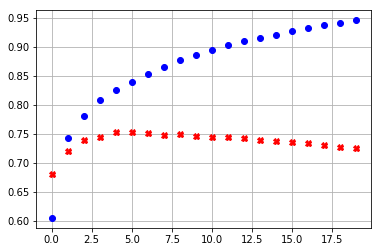

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the accuracy curves
plt.plot(history.history['acc'],'bo')
plt.plot(history.history['val_acc'],'rX')
plt.grid()

---
## Now test a Model with a first layer Embeddings on every input + LSTM + Dense

- Define the model
- Compile it
- Fit train data & evaluate with test data

In [51]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, LSTM

batch_size=32

model = Sequential()

model.add(Embedding(10000, 8))
model.add(LSTM(8, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=batch_size,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 8)           80000     
_________________________________________________________________
lstm_6 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 80,553
Trainable params: 80,553
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 14s 691us/step - loss: 0.6257 - acc: 0.6514 - val_loss: 0.5444 - val_acc: 0.7244
Epoch 2/20
20000/20000 [==============================] - 11s 572us/step - loss: 0.4927 - acc: 0.7630 - val_loss: 0.4974 - val_acc: 0.7502
Epoch 3/20
20000/20000 [==============================] - 12s 577us/step - 

In [52]:
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score with LSTM:', score)
print('Test accuracy with LSTM:', acc)

25000/25000 [==============================] - 2s 81us/step
Test score with LSTM: 0.5204155839347839
Test accuracy with LSTM: 0.7652


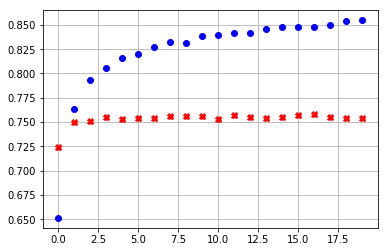

In [53]:
# Plot the accuracy curves
plt.plot(history.history['acc'],'bo')
plt.plot(history.history['val_acc'],'rX')
plt.grid()

## See Pre-trained models

https://nlp.stanford.edu/projects/glove/

## See Embeddings projector

http://projector.tensorflow.org/